
# Análise de Desempenho e Regressão Linear (dataset_24)


In [1]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

%matplotlib inline



## Parte I – Análise Estatística

Carregamento dos dados, tratamento de valores ausentes e análise descritiva inicial.


In [ ]:

df_original = pd.read_csv("dataset_24.csv")
df = df_original.copy()

print("Valores ausentes por coluna (Antes):")
print(df.isnull().sum())

for col in ["latencia_ms", "armazenamento_tb"]:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Valores ausentes em {col} imputados com a mediana ({median_val})")

for col in ["tipo_hd", "tipo_processador"]:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Valores ausentes em {col} com a moda ({mode_val})\n")

print("\nValores ausentes: ")
print(df.isnull().sum())

print("\nAnálise Descritiva - Variáveis Numéricas: ")
desc_num = df.describe()
print(desc_num)
print("\nAnálise Descritiva - Variáveis Categóricas: ")
desc_cat = df.describe(include=["object", "category"])
print(desc_cat)

print("\nContagem de Valores - sistema_operacional:")
print(df["sistema_operacional"].value_counts())
print("\nContagem de Valores - tipo_hd:")
print(df["tipo_hd"].value_counts())
print("\nContagem de Valores - tipo_processador:")
print(df["tipo_processador"].value_counts())

df.to_csv("dataset_24_limpo.csv", index=False)

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)




Valores ausentes por coluna (Antes):
cpu_cores               0
ram_gb                  0
latencia_ms            19
armazenamento_tb       19
sistema_operacional     0
tipo_hd                19
tipo_processador        1
tempo_resposta          0
dtype: int64
Valores ausentes em latencia_ms imputados com a mediana (145.54)
Valores ausentes em armazenamento_tb imputados com a mediana (0.512)
Valores ausentes em tipo_hd com a moda (SSD)

Valores ausentes em tipo_processador com a moda (Apple Silicon)


Valores ausentes: 
cpu_cores              0
ram_gb                 0
latencia_ms            0
armazenamento_tb       0
sistema_operacional    0
tipo_hd                0
tipo_processador       0
tempo_resposta         0
dtype: int64

Análise Descritiva - Variáveis Numéricas: 
        cpu_cores      ram_gb  latencia_ms  armazenamento_tb  tempo_resposta
count  194.000000  194.000000   194.000000        194.000000      194.000000
mean     8.335052   23.402062   148.577577          0.829938      

<ipython-input-3-d4a2197ff9c6>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
<ipython-input-3-d4a2197ff9c6>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me


## Parte II – Modelo e Diagnóstico

Ajuste do modelo de regressão linear múltipla e diagnósticos.



### Modelo 1: Regressão Linear Múltipla (Todas as Variáveis)

Tratamento de variáveis categóricas com One-Hot Encoding e ajuste do modelo OLS.


In [ ]:

df_limpo = pd.read_csv("dataset_24_limpo.csv")
cat_cols = ["sistema_operacional", "tipo_hd", "tipo_processador"]

df_encoded1 = pd.get_dummies(df_limpo, columns=cat_cols, drop_first=True, dtype=int)

y1 = df_encoded1["tempo_resposta"]
X1 = df_encoded1.drop("tempo_resposta", axis=1)

X1 = sm.add_constant(X1)

modelo1 = sm.OLS(y1, X1)
resultados1 = modelo1.fit()

print("--- Sumário Modelo 1 (Original) ---")
print(resultados1.summary())

print("--- Categorias Base (Modelo 1) ---")
for col in cat_cols:
    original_categories = set(df_limpo[col].unique())
    dummy_columns = {c.split(f'{col}_')[-1] for c in X1.columns if c.startswith(f'{col}_')}
    base_categories = original_categories - dummy_columns
    if len(base_categories) == 1:
        print(f"- {col}: {list(base_categories)[0]}")
    else:
        print(f"- {col}: Não foi possível determinar a categoria base automaticamente (categorias encontradas: {base_categories})")





--- Sumário Modelo 1 (Original) ---
                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     52.44
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.29e-43
Time:                        21:58:13   Log-Likelihood:                -1008.5
No. Observations:                 194   AIC:                             2035.
Df Residuals:                     185   BIC:                             2064.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------


### Diagnóstico de Multicolinearidade

Cálculo do Fator de Inflação da Variância (VIF).


In [ ]:

X_vif = X1.drop("const", axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

try:
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
except Exception as e:
    print(f"Erro ao calcular VIF: {e}")
    vifs = []
    for i in range(len(X_vif.columns)):
        try:
            v = variance_inflation_factor(X_vif.values, i)
        except Exception:
            v = float('inf')
        vifs.append(v)
    vif_data["VIF"] = vifs

print("--- Fator de Inflação da Variância (VIF) ---")
print(vif_data)

print("--- Interpretação VIF ---")
high_vif = vif_data[vif_data["VIF"] > 10]
inf_vif = vif_data[np.isinf(vif_data["VIF"])]

if not inf_vif.empty:
    print("Multicolinearidade PERFEITA detectada (VIF = inf) nas seguintes variáveis:")
    print(inf_vif)
    print("Ação é necessária (remoção de variável).")
elif not high_vif.empty:
    print("Multicolinearidade potencialmente problemática detectada (VIF > 10) nas seguintes variáveis:")
    print(high_vif)
    print("Ações podem ser necessárias, como remover variáveis.")
else:
    moderate_vif = vif_data[(vif_data["VIF"] > 5) & (vif_data["VIF"] <= 10)]
    if not moderate_vif.empty:
        print("Multicolinearidade moderada detectada (5 < VIF <= 10) nas seguintes variáveis:")
        print(moderate_vif)
    else:
        print("Não foi detectada multicolinearidade significativa (VIF <= 5 para todas as variáveis).")

vif_sorted = vif_data.sort_values(by="VIF", ascending=False)
print("\nVIF Ordenados do Maior para o Menor:")
print(vif_sorted)



--- Fator de Inflação da Variância (VIF) ---
                          feature       VIF
0                       cpu_cores  4.319992
1                          ram_gb  2.117906
2                     latencia_ms  3.489667
3                armazenamento_tb  2.713309
4       sistema_operacional_MacOS       inf
5     sistema_operacional_Windows  2.078571
6                     tipo_hd_SSD  2.285290
7  tipo_processador_Apple Silicon       inf
8          tipo_processador_Intel  2.016325
--- Interpretação VIF ---
Multicolinearidade PERFEITA detectada (VIF = inf) nas seguintes variáveis:
                          feature  VIF
4       sistema_operacional_MacOS  inf
7  tipo_processador_Apple Silicon  inf
Ação é necessária (remoção de variável).

VIF Ordenados do Maior para o Menor:
                          feature       VIF
4       sistema_operacional_MacOS       inf
7  tipo_processador_Apple Silicon       inf
0                       cpu_cores  4.319992
2                     latencia_ms  3.48966

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



### Diagnóstico de Heterocedasticidade

Análise gráfica (Resíduos vs. Valores Ajustados) e Teste de Breusch-Pagan.


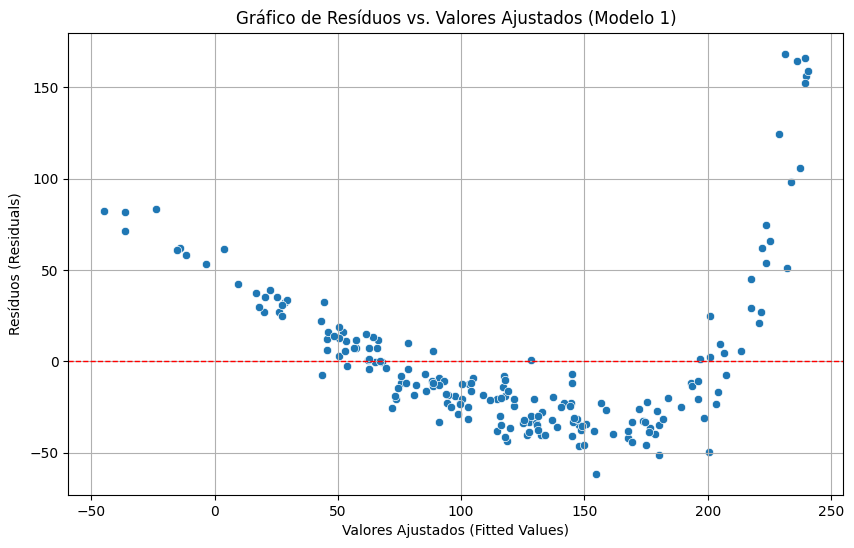

Gráfico salvo em residuals_vs_fitted_notebook.png
--- Teste de Breusch-Pagan (Modelo 1) ---
Estatística LM: 24.1319
p-valor LM: 0.0041
Estatística F: 3.2852
p-valor F: 0.0016
Interpretação: Com p-valor F (0.0016) < 0.05, rejeitamos H0.
Há evidência estatística de HETEROCEDASTICIDADE.


In [ ]:
residuos = resultados1.resid
valores_ajustados = resultados1.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=valores_ajustados, y=residuos)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Gráfico de Resíduos vs. Valores Ajustados (Modelo 1)")
plt.xlabel("Valores Ajustados (Fitted Values)")
plt.ylabel("Resíduos (Residuals)")
plt.grid(True)
plt.savefig("residuals_vs_fitted_notebook.png")
plt.show()
print("Gráfico salvo em residuals_vs_fitted_notebook.png")

print("--- Teste de Breusch-Pagan (Modelo 1) ---")
teste_bp = sms.het_breuschpagan(residuos, resultados1.model.exog)
nomes = ["Estatística LM", "p-valor LM", "Estatística F", "p-valor F"]
resultados_bp = dict(zip(nomes, teste_bp))

print(f"Estatística LM: {resultados_bp['Estatística LM']:.4f}")
print(f"p-valor LM: {resultados_bp['p-valor LM']:.4f}")
print(f"Estatística F: {resultados_bp['Estatística F']:.4f}")
print(f"p-valor F: {resultados_bp['p-valor F']:.4f}")




## Parte III – Análise Crítica

Comparação de modelos e recomendações práticas.



### Comparação de Modelos

Criação do Modelo 2 (removendo variável com VIF infinito) e comparação com o Modelo 1.


--- Sumário Modelo 2 (Excluindo tipo_processador_Apple Silicon) ---
                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     52.44
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.29e-43
Time:                        00:24:37   Log-Likelihood:                -1008.5
No. Observations:                 194   AIC:                             2035.
Df Residuals:                     185   BIC:                             2064.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

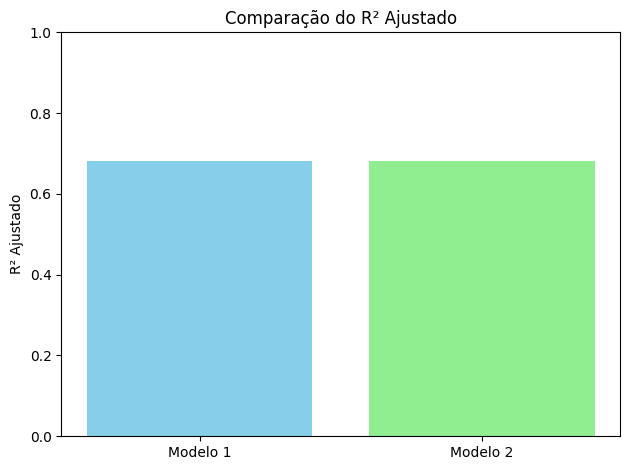

In [ ]:
df_encoded2 = pd.get_dummies(df_limpo, columns=cat_cols, drop_first=True, dtype=int)

vars_to_drop_model2 = ["tempo_resposta", "tipo_processador_Apple Silicon"]
X2 = df_encoded2.drop(columns=vars_to_drop_model2)
y2 = df_encoded2["tempo_resposta"]

X2 = sm.add_constant(X2)
modelo2 = sm.OLS(y2, X2)
resultados2 = modelo2.fit()

print("--- Sumário Modelo 2 (Excluindo tipo_processador_Apple Silicon) ---")
print(resultados2.summary())

print("--- Comparação dos Modelos ---")
print(f"Modelo 1: R² Adj = {resultados1.rsquared_adj:.4f}, F-stat = {resultados1.fvalue:.2f}, p(F) = {resultados1.f_pvalue:.2e}, Cond. No. = {np.linalg.cond(X1):.2e}")
print(f"Modelo 2: R² Adj = {resultados2.rsquared_adj:.4f}, F-stat = {resultados2.fvalue:.2f}, p(F) = {resultados2.f_pvalue:.2e}, Cond. No. = {np.linalg.cond(X2):.2f}")


plt.bar(["Modelo 1", "Modelo 2"], [resultados1.rsquared_adj, resultados2.rsquared_adj], color=["skyblue", "lightgreen"])
plt.title("Comparação do R² Ajustado")
plt.ylabel("R² Ajustado")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

